In [1]:
!pip install --upgrade gym

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 9.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827616 sha256=e3a5127406aa49d9edf17e1b2767520389ed581351de608fd911fb217287aa8f
  Stored in directory: /root/.cache/pip/wheels/b9/22/6d/3e7b32d98451b4cd9d12417052affbeeeea012955d437da1da
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.6 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.


In [1]:
from gym.version import VERSION
print(VERSION)

0.26.2


In [2]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
from torch.optim import Adam, Optimizer
import numpy as np
import gym
from matplotlib import animation
import matplotlib.pyplot as plt

In [3]:
def create_model(number_observation_features: int, number_actions: int) -> nn.Module:
    """Create the MLP model

    Args:
        number_observation_features (int): Number of features in the (flat)
        observation tensor
        number_actions (int): Number of actions

    Returns:
        nn.Module: Simple MLP model
    """
    hidden_layer_features = 32

    return nn.Sequential(
        nn.Linear(in_features=number_observation_features,
                  out_features=hidden_layer_features),
        nn.ReLU(),
        nn.Linear(in_features=hidden_layer_features,
                  out_features=number_actions),
    )

In [4]:
def get_policy(model: nn.Module, observation: np.ndarray) -> Categorical:
    """Get the policy from the model, for a specific observation

    Args:
        model (nn.Module): MLP model
        observation (np.ndarray): Environment observation

    Returns:
        Categorical: Multinomial distribution parameterized by model logits
    """
    observation_tensor = torch.as_tensor(observation, dtype=torch.float32)
    logits = model(observation_tensor)

    # Categorical will also normalize the logits for us
    return Categorical(logits=logits)

In [5]:
def get_action(policy: Categorical) -> tuple[int, float]:
    """Sample an action from the policy

    Args:
        policy (Categorical): Policy

    Returns:
        tuple[int, float]: Tuple of the action and it's log probability
    """
    action = policy.sample()  # Unit tensor

    # Converts to an int, as this is what Gym environments require
    action_int = action.item()

    # Calculate the log probability of the action, which is required for
    # calculating the loss later
    log_probability_action = policy.log_prob(action)

    return action_int, log_probability_action

In [6]:
def calculate_loss(epoch_log_probability_actions: torch.Tensor, epoch_action_rewards: torch.Tensor) -> float:
    """Calculate the 'loss' required to get the policy gradient

    Formula for gradient at
    https://spinningup.openai.com/en/latest/spinningup/rl_intro3.html#deriving-the-simplest-policy-gradient

    Note that this isn't really loss - it's just the sum of the log probability
    of each action times the episode return. We calculate this so we can
    back-propagate to get the policy gradient.

    Args:
        epoch_log_probability_actions (torch.Tensor): Log probabilities of the
            actions taken
        epoch_action_rewards (torch.Tensor): Rewards for each of these actions

    Returns:
        float: Pseudo-loss
    """
    # return -(epoch_log_probability_actions * epoch_action_rewards).mean()

    if epoch_log_probability_actions.size(0) != epoch_action_rewards.size(0):
        # Pad or truncate to make the sizes along dimension 0 equal
        min_size = min(epoch_log_probability_actions.size(0), epoch_action_rewards.size(0))
        epoch_log_probability_actions = epoch_log_probability_actions[:min_size]
        epoch_action_rewards = epoch_action_rewards[:min_size]

    return -(epoch_log_probability_actions * epoch_action_rewards).mean()


In [7]:
frames = []

def save_frames_as_gif(frames, path='./', filename='gym_animation.gif'):

    #Mess with this to change frame size
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)

    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    anim.save(path + filename, writer='imagemagick', fps=60)

In [8]:
def train_one_epoch(env: gym.Env, model: nn.Module, optimizer: Optimizer, max_timesteps=100, episode_timesteps=200) -> float:
    """Train the model for one epoch

    Args:
        env (gym.Env): Gym environment
        model (nn.Module): Model
        optimizer (Optimizer): Optimizer
        max_timesteps (int, optional): Max timesteps per epoch. Note if an
            episode is part-way through, it will still complete before finishing
            the epoch. Defaults to 5000.
        episode_timesteps (int, optional): Timesteps per episode. Defaults to 200.

    Returns:
        float: Average return from the epoch
    """
    epoch_total_timesteps = 0

    # Returns from each episode (to keep track of progress)
    epoch_returns: list[int] = []

    # Action log probabilities and rewards per step (for calculating loss)
    epoch_log_probability_actions = []
    epoch_action_rewards = []

    # Loop through episodes
    while True:

        # Stop if we've done over the total number of timesteps
        if epoch_total_timesteps > max_timesteps:
            break

        # Running total of this episode's rewards
        episode_reward: int = 0

        # Reset the environment and get a fresh observation
        observation, _ = env.reset()

        # Loop through timesteps until the episode is done (or the max is hit)
        for timestep in range(episode_timesteps):
            # env.render()
            epoch_total_timesteps += 1

            # Get the policy and act
            policy = get_policy(model, observation)
            action, log_probability_action = get_action(policy)

            # env.render()
            frames.append(env.render())

            observation, reward, done, _, _= env.step(action)

            # Increment the episode rewards
            episode_reward += reward

            # Add epoch action log probabilities
            epoch_log_probability_actions.append(log_probability_action)

            # Finish the action loop if this episode is done
            if done == True:
                # Add one reward per timestep
                for _ in range(timestep + 1):
                    epoch_action_rewards.append(episode_reward)

                break

        # Increment the epoch returns
        epoch_returns.append(episode_reward)

    # Calculate the policy gradient, and use it to step the weights & biases
    epoch_loss = calculate_loss(torch.stack(
        epoch_log_probability_actions),
        torch.as_tensor(
        epoch_action_rewards, dtype=torch.float32)
    )

    epoch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return np.mean(epoch_returns)

epoch:   0 	 return: 27.500
epoch:   1 	 return: 18.167
epoch:   2 	 return: 22.200
epoch:   3 	 return: 20.800
epoch:   4 	 return: 16.286
epoch:   5 	 return: 22.400
epoch:   6 	 return: 26.250
epoch:   7 	 return: 18.833
epoch:   8 	 return: 26.800
epoch:   9 	 return: 16.833
epoch:  10 	 return: 27.000
epoch:  11 	 return: 23.200
epoch:  12 	 return: 21.000
epoch:  13 	 return: 27.500
epoch:  14 	 return: 41.000
epoch:  15 	 return: 25.250
epoch:  16 	 return: 22.200
epoch:  17 	 return: 22.200
epoch:  18 	 return: 35.750
epoch:  19 	 return: 29.500
epoch:  20 	 return: 32.250
epoch:  21 	 return: 17.000
epoch:  22 	 return: 17.333
epoch:  23 	 return: 49.333
epoch:  24 	 return: 22.000
epoch:  25 	 return: 42.000
epoch:  26 	 return: 31.000
epoch:  27 	 return: 21.800
epoch:  28 	 return: 25.250
epoch:  29 	 return: 27.500
epoch:  30 	 return: 27.200
epoch:  31 	 return: 37.000
epoch:  32 	 return: 45.750
epoch:  33 	 return: 40.000
epoch:  34 	 return: 24.333
epoch:  35 	 return:

epoch:  39 	 return: 23.400


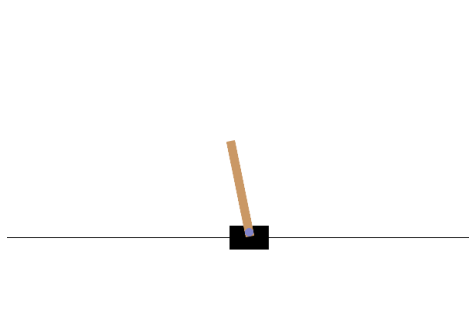

In [9]:
def train(epochs=40) -> None:
    """Train a Vanilla Policy Gradient model on CartPole

    Args:
        epochs (int, optional): The number of epochs to run for. Defaults to 50.
    """

    # Create the Gym Environment
    env = gym.make('CartPole-v1', render_mode='rgb_array')

    torch.manual_seed(0)
    env.action_space.seed(0)

    # Create the MLP model
    number_observation_features = env.observation_space.shape[0]
    number_actions = env.action_space.n
    model = create_model(number_observation_features, number_actions)

    # Create the optimizer
    optimizer = Adam(model.parameters(), 1e-2)

    # Loop for each epoch
    for epoch in range(epochs):
        average_return = train_one_epoch(env, model, optimizer)
        print('epoch: %3d \t return: %.3f' % (epoch, average_return))

    env.close()
    save_frames_as_gif(frames)


if __name__ == '__main__':
    train()